# Capstone - Feature Engineering and Modelling Part II
Date: 2021.11.27<br>
William Matthews

### Report Objectives and Flow

This report will implement the learnings from the EDA and Modelling Part I report with the goal of increasing the overall accuracy, the precision, and the recall of our models in predicting if the Peak chair at Whistler will open on a given day.  We will engineer at least one additional feature as well as remove features we have identified as un-consequential.

The models in this report will utilize a composite dataset from the Port Hardy and Quillayute weather balloon stations.  Because of this, we will run a suite of models against our data to determine the effect of this change before moving onto any other feature engineering or manipulation.  After each change in features, we will re-run our models to get an understanding of the value of the work we have done on the features.  Finally, we will pick our best model and run hyperparameterization against it.

### Data Sets

We will be bringing in 4 data sets for this model building.  We will be using the _PowDayHistory_ as our target variables, and the _RoundHouseClean_ data and _CombinedBallonDataCleaned_ for our features.  We will also be bringing in _BaseLineModelScores_ which contains the confusion matrix values for all the models previously run on our data.  We will use this to evaluate the effectiveness of removing some noisy data as well as the effectiveness of features we engineer.

### Library and Data Imports

In [247]:
# data handling
import numpy as np
import pandas as pd

# managing timestamps
from datetime import datetime
from datetime import timedelta

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# text manipulation
from textwrap import wrap

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# set font size for all plots
mpl.rcParams.update({'font.size': 16})
# allow

In [275]:
# import data
pow_day_df = pd.read_csv('./Data/PowDayHistoryClean.csv')
balloon_df = pd.read_csv('./Data/CombinedBalloonDataClean.csv')
rh_df = pd.read_csv('./Data/RoundHouseClean.csv')
scores_df = pd.read_csv('./Data/BaseLineModelScores.csv')

In [139]:
# confirm things imported as expected
display(pow_day_df,
        balloon_df,
        rh_df,
        scores_df)

,time,lift,day_status
0,2014-12-31 00:00:00,Whistler Village Gondola,0
1,2014-12-31 00:00:00,Jersey Cream,0
2,2014-12-31 00:00:00,Crystal,0
3,2014-12-31 00:00:00,7th Heaven,0
4,2014-12-31 00:00:00,Glacier,0
...,...,...,...
26259,2021-03-29 09:28:27,Peak,1
26260,2021-03-29 10:09:30,Harmony,1
26261,2021-03-29 10:14:06,Excalibur Gondola,1
26262,2021-03-29 10:30:08,Symphony,1


,DATE,TEMP,DWPT,RELH,MIXR,DRCT,SKNT
0,2014-12-31 16:00:00,-1.200000,-10.200000,50.000000,2.525000,15.000000,19.000000
1,2015-01-01 04:00:00,-0.822222,-12.644444,40.555556,2.111111,340.555556,12.888889
2,2015-01-01 16:00:00,-2.100000,-10.175000,55.250000,2.615000,335.000000,16.250000
3,2015-01-02 04:00:00,-2.320000,-7.220000,69.400000,3.186000,280.800000,35.600000
4,2015-01-02 16:00:00,-4.225000,-41.975000,3.750000,0.147500,289.500000,39.250000
...,...,...,...,...,...,...,...
2430,2021-04-14 16:00:00,-0.720000,-22.280000,17.800000,0.922000,64.800000,17.600000
2431,2021-04-15 04:00:00,-2.500000,-13.833333,41.666667,1.883333,61.666667,14.000000
2432,2021-04-15 16:00:00,-1.825000,-19.175000,25.500000,1.227500,80.750000,11.000000
2433,2021-04-16 04:00:00,-0.640000,-21.900000,19.200000,0.984000,90.800000,10.000000


,Date/Time,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Snow on Grnd (cm)
0,2015-01-01,4.5,0.5,2.5,0.0,0,0.0,1,117.0
1,2015-01-02,-3.0,-6.0,-4.5,0.0,0,0.0,1,116.0
2,2015-01-03,-6.0,-9.0,-7.5,0.0,0,5.0,0,115.0
3,2015-01-04,0.0,-8.0,-4.0,0.0,0,33.0,0,132.0
4,2015-01-05,3.0,-5.0,-1.0,23.0,0,6.0,0,149.0
...,...,...,...,...,...,...,...,...,...
932,2021-03-25,2.0,-6.0,-2.0,0.0,0,0.0,0,280.0
933,2021-03-26,1.0,-5.5,-2.3,0.0,0,0.0,0,275.0
934,2021-03-27,-0.5,-4.5,-2.5,0.0,0,14.0,0,274.0
935,2021-03-28,-3.5,-5.5,-4.5,0.0,0,15.0,0,287.0


,Unnamed: 0,True Negative,False Positive,False Negative,True Positive
0,Base_Line_Logistic,22,24,25,130
1,Base_Line_Tree,29,17,21,134
2,Base_Line_KNN,17,29,10,145
3,Base_Line_Forest,25,21,8,147
4,Base_Line_SVM,21,25,10,145


In [276]:
# clean up header of scores_df
scores_df.rename(columns = {'Unnamed: 0': 'Model Name'}, inplace = True)

In [277]:
# add a Model Iteration Field as the second column and extract Base from first column
scores_df.insert(1, 'Model Iteration', scores_df['Model Name'].apply(lambda x: x[0:9]))

In [278]:
# remove the Base_ prefix from the Model Name column
scores_df['Model Name'] = scores_df['Model Name'].apply(lambda x: x[10:])

In [279]:
# update names to proper names so we can use them in graph titles
for i in range(scores_df.shape[0]):
    if scores_df.iloc[i, 0] == 'Logistic':
        scores_df.iloc[i, 0] = 'Logistic Regression'
    if scores_df.iloc[i, 0] == 'Tree':
        scores_df.iloc[i, 0] = 'Decision Tree'
    if scores_df.iloc[i, 0] == 'Forest':
        scores_df.iloc[i, 0] = 'Random Forest'
    

In [280]:
# check manipulations worked
scores_df

,Model Name,Model Iteration,True Negative,False Positive,False Negative,True Positive
0,Logistic Regression,Base_Line,22,24,25,130
1,Decision Tree,Base_Line,29,17,21,134
2,KNN,Base_Line,17,29,10,145
3,Random Forest,Base_Line,25,21,8,147
4,SVM,Base_Line,21,25,10,145


Our data was successfully imported.  On import, we realized our scores data frame could be better structured, so we split one of the columns into two to help with data tracking down the line.  Let's check the columns quickly before moving on.

In [9]:
display(pow_day_df.info(),
        balloon_df.info(),
        rh_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26264 entries, 0 to 26263
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   time        26264 non-null  object
 1   lift        26264 non-null  object
 2   day_status  26264 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 615.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2435 entries, 0 to 2434
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    2435 non-null   object 
 1   TEMP    2435 non-null   float64
 2   DWPT    2435 non-null   float64
 3   RELH    2435 non-null   float64
 4   MIXR    2435 non-null   float64
 5   DRCT    2435 non-null   float64
 6   SKNT    2435 non-null   float64
dtypes: float64(6), object(1)
memory usage: 133.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dty

None

None

None

It looks like everything is good with the exceptin of the date and time columns.  Let's change these to date time objects.

In [10]:
# change all date/time columns to datetime objects
pow_day_df['time'] = pd.to_datetime(pow_day_df['time'])
balloon_df['DATE'] = pd.to_datetime(balloon_df['DATE'])
rh_df['Date/Time'] = pd.to_datetime(rh_df['Date/Time'])

### Data Wrangling

Here we are going to focus on constructing a data frame where each row consists of a target and each of its features.  Because we are going to be using the lags, or the data from the preceeding days as well, we are going to build out our data frame with column names very similar to how we did it in our _EDAAndModellingPartI_ report.

The biggest difference between the previous report and this one is that we are going to cap the lag values at three days max instead of 5.  After discussion with weather experts, they felt it was unlikely that anything past one to two days lag would have much effect on the opening of the Peak chair.

Let's move on to complete all of the transformations we did in our previous report.

In [ ]:
# get an empty list of column names to build column names on
col_names = []

# list of lag values to attach to each column from ballon data
ballon_suffixes = []
for lag in range(0, 96, 12):
    ballon_suffixes.append(f"_L{lag}h")
    
# build column names from balloon dataset
# loop through all columns
for col in balloon_df.columns:
    
    # don't take the date column
    if col != 'DATE':
        
        # add each suffix to the column name
        for lag in ballon_suffixes:
            col_names.append(f"{col}{lag}")

# build lag suffixes for powday and roundhouse data
pow_rh_suffixes = []
for lag in range(0,73, 24):
    pow_rh_suffixes.append(f"_L{lag}h")

# build column names for roundhouse data
for col in rh_df.columns:
    
    # don't take the date/time column
    if col != 'Date/Time':
        
        # add each suffix to the column name
        for lag in pow_rh_suffixes:
            col_names.append(f"{col}{lag}")

# build column names for powday data
col = 'day_status'

# add each suffix to the column name
for lag in pow_rh_suffixes:
    col_names.append(f"{col}{lag}")

# add a day of the week column
col_names.append('day_of_week')

# check to see it all has worked
col_names

In [ ]:
# extract all unique dates from the date-time column
ref_dates = pow_day_df['time'].apply(lambda d: d.date()).unique()

# build data frame and fill with NaN values
model_template_df = pd.DataFrame(np.NaN, index = ref_dates, columns = col_names)

# check to see it worked
model_template_df

In [ ]:
# fill all Balloon data points

# loop through all target dates
for target_date in model_template_df.index:

    # force target date time to match first expected record (4PM for the current day)
    target_date_with_time = datetime(target_date.year, target_date.month, target_date.day, 16)
    
    # loop to cycle through all of our lags
    for lag in range(0, 96, 12):

        # get record for correct lag period
        lag_record = balloon_df[balloon_df['DATE'].apply(lambda d: d + timedelta(hours = lag)) == target_date_with_time]
        
        # get the number of rows in the lag_record
        num_rows = lag_record.shape[0]
        
        # if we have more than one row in our lag record, assert an error
        if num_rows > 1:
            assert True, f'We have a duplicate lag record at indicies {lag_record.index}'
        
        # if we have exactly one row, proceed
        elif num_rows == 1:
            
            # loop to cycle through all columns in lag_recrods except Date/Time
            for col in lag_record.columns:
                
                # proceed if col is NOT date/time
                if col != 'DATE':
                    
                    # compose target column name from column extracted, and lag value
                    target_column_suffix = f"_L{abs(lag)}h"
                    target_column = f"{col}{target_column_suffix}"

                    # write the lag_record to the correct row in model_template
                    model_template_df.loc[target_date, target_column] = lag_record[col].values[0]

        # if the value is 0, do nothing and leave NaN values in our data frame
        else:
            pass     

In [ ]:
# check to see things went as expected.
model_template_df

In [ ]:
# fill all Roundhouse trailing data points

# loop through all target dates
for target_date in model_template_df.index:
    
    # loop to cycle through all of our lags - must be in hours to match with column names
    for lag in range(0, 73, 24):

        # get record for correct lag period
        lag_record = rh_df[rh_df['Date/Time'].apply(lambda d: d.date() + timedelta(days = lag/24)) == target_date]
        
        # get the number of rows in the lag_record
        num_rows = lag_record.shape[0]
        
        # if we have more than one row in our lag record, assert an error
        if num_rows > 1:
            assert True, f'We have a duplicate lag record at indicies {lag_record.index}'
        
        # if we have exactly one row, proceed
        elif num_rows == 1:
            
            # loop to cycle through all columns in lag_recrods except Date/Time
            for col in lag_record.columns:
                
                # proceed if col is NOT date/time
                if col != 'Date/Time':
                    
                      # compose target column name from column extracted, and lag value
                    target_column_suffix = f"_L{abs(lag)}h"
                    target_column = f"{col}{target_column_suffix}"

                    # write the lag_record to the correct row in model_template
                    model_template_df.loc[target_date, target_column] = lag_record[col].values[0]

        # if the value is 0, do nothing and leave NaN values in our data frame
        else:
            pass     

In [16]:
day_of_week = []

for i in range(0, model_template_df.shape[0]):
    day_of_week.append(model_template_df.index[i].strftime('%a'))

model_template_df['day_of_week'] = day_of_week

model_template_df

,TEMP_L0h,TEMP_L12h,TEMP_L24h,TEMP_L36h,TEMP_L48h,TEMP_L60h,TEMP_L72h,TEMP_L84h,DWPT_L0h,DWPT_L12h,...,Total Snow Flag_L72h,Snow on Grnd (cm)_L0h,Snow on Grnd (cm)_L24h,Snow on Grnd (cm)_L48h,Snow on Grnd (cm)_L72h,day_status_L0h,day_status_L24h,day_status_L48h,day_status_L72h,day_of_week
2014-12-31,-1.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.200000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wed
2015-01-01,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,NaN,NaN,-10.175000,-12.644444,...,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thu
2015-01-02,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,-41.975000,-7.220000,...,NaN,116.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,Fri
2015-01-03,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,-23.112500,-39.440000,...,NaN,115.0,116.0,117.0,NaN,NaN,NaN,NaN,NaN,Sat
2015-01-04,0.050000,-4.250000,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,0.000000,-5.766667,...,1.0,132.0,115.0,116.0,117.0,NaN,NaN,NaN,NaN,Sun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-14.400000,-12.866667,-43.460000,-15.700000,...,0.0,280.0,285.0,284.0,289.0,NaN,NaN,NaN,NaN,Thu
2021-03-26,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-23.833333,-9.125000,...,0.0,275.0,280.0,285.0,284.0,NaN,NaN,NaN,NaN,Fri
2021-03-27,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-13.250000,-16.342857,...,1.0,274.0,275.0,280.0,285.0,NaN,NaN,NaN,NaN,Sat
2021-03-28,-18.300000,-13.320000,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-21.200000,-21.480000,...,0.0,287.0,274.0,275.0,280.0,NaN,NaN,NaN,NaN,Sun


In [17]:
# one hot encode day of week and drop the first day
model_template_df = pd.get_dummies(model_template_df,
                                   columns = ['day_of_week'],
                                   drop_first = True)

In [18]:
# list to store column names
drct_cols = []

# find all columns with DRCT in the column header
for col in model_template_df.columns:
    if col.find('DRCT') != -1:
        drct_cols.append(col)

# for each column in our subset
for col in drct_cols:
    
    # compose sin column name
    sin_col = f"sin_{col}"
    
    # calculate sin transform and store in a new column
    model_template_df[sin_col] = np.sin(model_template_df[col]/360*2*np.pi)
    
    # compose cos column name
    cos_col = f"cos_{col}"
    
    # calculate cos transform and store in a new column
    model_template_df[cos_col] = np.cos(model_template_df[col]/360*2*np.pi)
    
    # delete the original column
    model_template_df.drop(columns = col, inplace = True)

In [19]:
# check we have the columns we want.
model_template_df.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Rain Flag_L0h', 'Tot

The above transformations include building our data frame to accept 3 days of lag from each of our variables and writing the correct data from each data source into our constructed data frame.  It also includes transforming our wind direction feature from one column in degrees to two columns, the sin and cosine of the wind angle.  We now have a template into which we can insert any of our chair lifts.  For the purpose of this report we will be focussing on the Peak chair only.  Let's build out that dataframe now.

In [20]:
# create a copy
peak_df = model_template_df.copy(deep = True)

In [21]:
# fill all PowDay trailing data points

# loop through all target dates
for target_date in peak_df.index:
    
    # loop to cycle through all of our lags - must be in hours to match with column names
    for lag in range(0, 73, 24):

        # get record for correct lag period
        lag_record = pow_day_df[(pow_day_df['time'].apply(lambda d: d.date() + timedelta(days = lag/24)) == target_date) &
                                           (pow_day_df['lift'] == 'Peak')]
        
        # get the number of rows in the lag_record
        num_rows = lag_record.shape[0]
        
        # if we have more than one row in our lag record, assert an error
        if num_rows > 1:
            assert True, f'We have a duplicate lag record at indicies {lag_record.index}'
        
        # if we have exactly one row, proceed
        elif num_rows == 1:
            
            # extract the day_status column only
            col = 'day_status'
                
            # compose target column name from column extracted, and lag value
            target_column_suffix = f"_L{abs(lag)}h"
            target_column = f"{col}{target_column_suffix}"

            # write the lag_record to the correct row in model_template
            peak_df.loc[target_date, target_column] = lag_record[col].values[0]

        # if the value is 0, do nothing and leave NaN values in our data frame
        else:
            pass     

Now that we have placed all the data we have into our data frame, let's take a look at how many missing values we still have.

In [22]:
# total number of rows
rows = peak_df.shape[0]

# number of missing ros
missing_rows = rows - peak_df.dropna().shape[0]

print(f"Total rows: {rows}")
print(f"Missing rows: {missing_rows}")
print(f"Percent missing rows: {100*missing_rows/rows: .1f}%")

Total rows: 938
Missing rows: 65
Percent missing rows:  6.9%


It looks like our changes have reduced the number of missing rows from roughly 30% down to 6.5%.  Hopefully this will be enough to boost our models efficacy.  If not, we may have to look at another round of imputing.  Let's drop our missing rows and move on.

In [23]:
# drop all rows with NaN values
peak_df = peak_df.dropna()

### Preperation for Model Iterations

In order to track how our various scoring metrics are changing with each feature we drop our engineer, we are going to write a few helper functions that make it easy to fit, predicit, score, and visualize after each successive iteration.

In [232]:
def split_fit_score(current_df, iteration_num):
    """
    Takes a data frame of the current data set and string of current iteration, splits it into train and test, fits each of our models,
    scores each of our models, and returns a list of lists which contains model name, iteration, and confusion matrix values
    """
    # split data in to dependent and independent variables - drop the datetime column
    X = current_df.drop(columns = ['day_status_L0h'])
    y = current_df['day_status_L0h']

    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)

    # fit scaler on train data and transform
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # scale test data
    X_test_scaled = scaler.transform(X_test)
    
    # fit logistic model
    logmod = LogisticRegression()
    logmod.fit(X_train_scaled, y_train)

    # fit decision tree - don't worry about using scaled data
    tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
    tree.fit(X_train, y_train)

    # fit knn model
    knn = KNeighborsClassifier()
    knn.fit(X_train_scaled, y_train)

    # fit random forest model
    random_forest = RandomForestClassifier(random_state = 42)
    random_forest.fit(X_train, y_train)

    # fit svm model
    svm = SVC(random_state = 42)
    svm.fit(X_train_scaled, y_train)
    
    # run each models prediction again and save result of confusion matrix
    scores = []

    # logistic
    y_pred = logmod.predict(X_test_scaled)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

    # decision tree
    y_pred = tree.predict(X_test)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

    # knn
    y_pred = knn.predict(X_test_scaled)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

    # random forest
    y_pred = random_forest.predict(X_test)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

    # svm
    y_pred = svm.predict(X_test_scaled)
    scores.append(np.ravel(confusion_matrix(y_test, y_pred)))
    
    # build list of model names
    model_names = list(scores_df['Model Name'].unique())

    # build list of iteration number
    iteration_id = []
    for _ in model_names:
        iteration_id.append(iteration_num)

    # build list of all data to add to data frame
    latest_scores = []
    for model_name, iteration, score in zip(model_names, iteration_id, scores):
    
        # build empty list and add each element to it
        data = []
        data.append(model_name)
        data.append(iteration)
        # unpack the array into individual values to put into the list
        for s in score:
            data.append(s)

        # add the list to latest scores list
        latest_scores.append(data)
        
    return latest_scores

In [284]:
def plot_model_iterations(scores_df):
    """
    Takes a data frame of scores and produces a series of line plots for visualizing
    the changes over each model iteration.

    """
    
    # get a deep copy of the data frame so we don't mess with the scores_df
    df = scores_df.copy(deep = True)
    
    # calculate overall accuracy
    df['Accuracy'] = (df['True Positive'] + df['True Negative'])/ \
                     (df['True Positive'] + df['True Negative'] + 
                      df['False Positive'] + df['False Negative'])
    
    # calculate closed precision
    df['Precision-Closed'] = df['True Negative']/ \
                             (df['True Negative'] + df['False Negative'])
    
    # calculate closed recall
    df['Recall-Closed'] =  df['True Negative']/ \
                           (df['True Negative'] + df['False Positive'])
    
    # calculate open precision
    df['Precision-Open'] = df['True Positive']/ \
                           (df['True Positive'] + df['False Positive'])
                          
    # calculate open recall
    df['Recall-Open'] = df['True Positive']/ \
                           (df['True Positive'] + df['False Negative'])
    
    # change all score columns to percentages, rounded to 0 decimals
    df[['Accuracy', 'Precision-Closed', 'Recall-Closed',
        'Precision-Open', 'Recall-Open']] = df[['Accuracy', 'Precision-Closed', 'Recall-Closed',
                                                'Precision-Open', 'Recall-Open']].apply(lambda x: round(x*100, 0))

    # get list of model names
    models = list(df['Model Name'].unique())
    
    # work out number of rows needed based on number of columns
    figure_cols = 2
    figure_rows = int(np.ceil((len(models))/figure_cols)) 
    
    # plot one subplot per model name, plus an overall plot for accuracy, precision, recall
    fig, axes = plt.subplots(figure_rows,
                             figure_cols,
                             figsize = (figure_cols*6, figure_rows*4.5 ))
    
    # flaten out axes array
    flat_ax = np.ravel(axes)
    
    # line plots for each model plot, remove last axis
    for ax, model in zip(flat_ax[:-1], models):
        
        # filter the df by the model
        df_to_plot = df[df['Model Name'] == model]
        
        # plot the data
        ax.plot(df_to_plot['Model Iteration'],
                df_to_plot[['Accuracy', 'Precision-Closed', 'Recall-Closed', 'Precision-Open', 'Recall-Open']],
                label = ['Accuracy', 'Precision-Closed', 'Recall-Closed', 'Precision-Open', 'Recall-Open'])

        
        # set the xticks to be minimum of 5 (will make the visuals easier to compare over time)
        ax.set_xticks(np.arange(0, max(len(models), 5), 1))
        
        # set yaxis limits to be matching for all
        ax.set_ylim(30, 100)
        
        # set title of subplot
        ax.set_title(f"{model}")
        
        # add x labels
        ax.set_xlabel('Model Iteration')
        
        # add y-labels
        ax.set_ylabel('Percentage of Metric')
        
        # add grid lines
        ax.grid()
        
        # store last axis info for creating unified legend
        handles, labels = ax.get_legend_handles_labels()
        
    # add figure title
    fig.suptitle('Model Performance Metrics Over Feature\nEngineering and Removal')
    
    # turn off the last axis to leave room for the legends
    flat_ax[-1].axis('off')

    # update legend labels with best score and which model
    for i, metric in enumerate(labels):
        
        # get the index of the best row
        index_best_row = df[metric].idxmax()
        
        # get best score and best model name
        best_score = df.loc[index_best_row, metric]
        best_model = df.loc[index_best_row, 'Model Name']
       
        # build string
        new_label = f"{metric} (Best is {best_score: .0f}% from {best_model})"
        
        # put string back into labels
        labels[i] = new_label
    
    # force labels for wrap in the legend
    labels = [ '\n'.join(wrap(l, 30)) for l in labels]
    
    # add legend for  model metrics to figure
    fig.legend(handles, labels,
               title = 'Model Metrics',
               bbox_to_anchor = (0.95, 0.3))
    
    # align layout
    fig.tight_layout()
    
    plt.show()

_Credit to [this StackOverflow post](https://stackoverflow.com/questions/47057789/matplotlib-wrap-text-in-legend) for the solution to wrap text in a legend_

### Model Iteration I - Decreasing Data Loss

The purpose of this first iteration is to see the effect of the changes we have made since the base line model.  These changes are:
- Combining the weather ballon data into one dataset to eliminate as many null values as possible
- Deleting the pressure and height columns from the ballon data sets
- Reducing the number of lag days for each variable from 5 to 3.<br>

Let's run each of the models we previously ran again and see how they compared against our baseline.

Accuracy
89.0
Logistic Regression
Precision-Closed
91.0
SVM
Recall-Closed
65.0
Logistic Regression
Precision-Open
90.0
Logistic Regression
Recall-Open
99.0
Random Forest


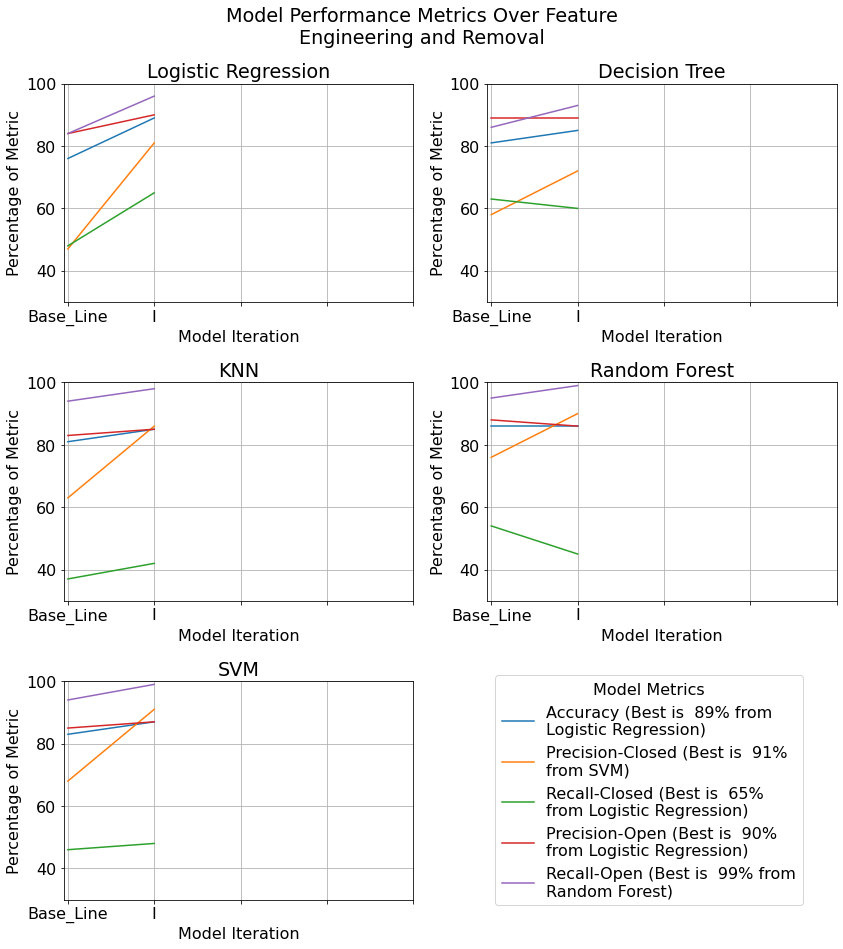

In [281]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df, 'I')

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

Our first model iteration has produced a mixture of results.  Most noteable:
- Logistic regression saw significant improvements across metrics and has gone from being our worst performing model to our best in terms of overall accuracy.
- Both our Random Forest and Decision Tree Models saw a dip in the recall of closed days.  This is unfortunate as we have been having trouble with accurately predicting closed days as closed up to this point.

### Model Iteration II - Dropping Day of the Week

One of the variables we thought would be useful to add into our model was day of the week.  After running some Chi Squared tests for significance it turns out day of the week was not a useful factor.  Let's drop it and then re-run our models to see if there is any significant effect.  We are expecting to see little movement in the metrics.

In [282]:
# get all the day of the week column names
day_of_week_cols = [col for col in peak_df.columns if col.find('day_of_week') != -1]

# drop day of week columns and make a deep copy of the data frame
peak_df1 = peak_df.drop(columns = day_of_week_cols).copy(deep = True)

# check it worked
peak_df1.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Rain Flag_L0h', 'Tot

Accuracy
89.0
Logistic Regression
Precision-Closed
93.0
KNN
Recall-Closed
65.0
Logistic Regression
Precision-Open
90.0
Logistic Regression
Recall-Open
99.0
Random Forest


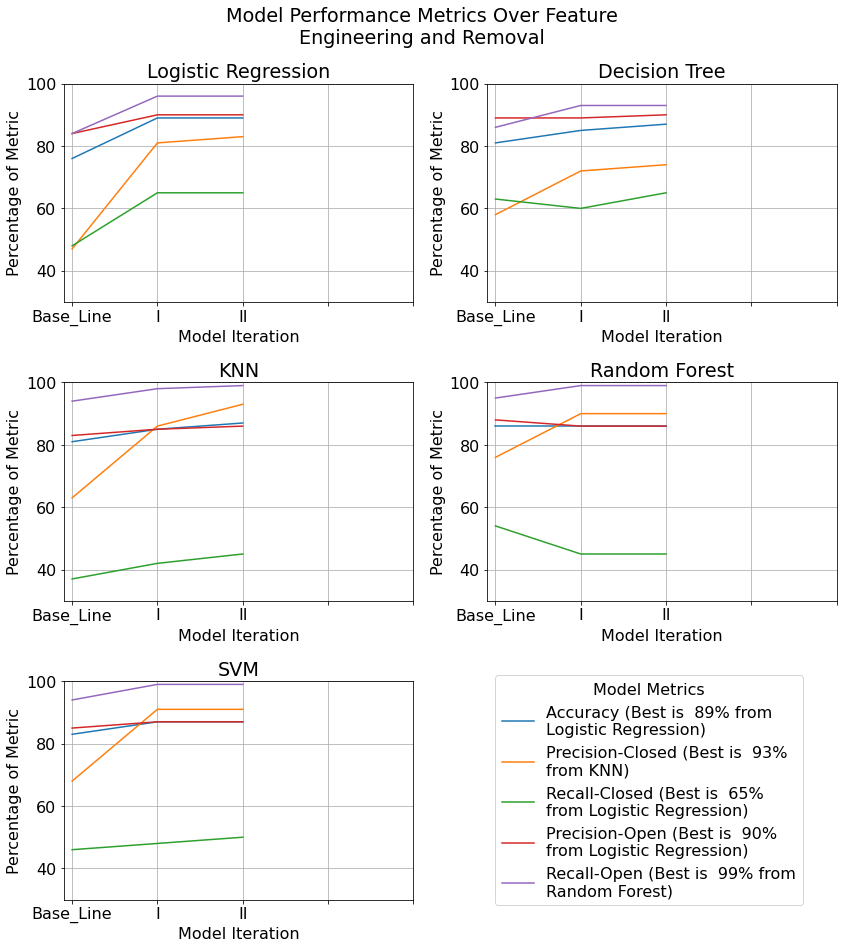

In [283]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df1, 'II')

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

As expected, there was very little chance in any of the metrics.  The great news is that none of the values decreased, and a few even increased.  Notably:
- The decision tree model saw increases in precision and recall of closed days.
- The logistic model saw an increase in the precision of closed days.
- The KNN mdoel saw an increase in the precision of closed days.

### Model Iteration III - Droping Rain/Snow Fall Flags

Based on the discussion and proof during our EDA, the rain fall and snow fall flag variables have very weak correlations with the chance of the Peak chair opening.  We are going to drop them from our data set.  Again, we are expecting littl echange in model performance.

In [285]:
# get all the day of the falg column names
flag_cols = [col for col in peak_df.columns if col.find('Flag_') != -1]

# drop flag columns and make a deep copy of the data frame
peak_df2 = peak_df1.drop(columns = flag_cols).copy(deep = True)

# check it worked
peak_df2.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Snow (cm)_L0h', 'Tot

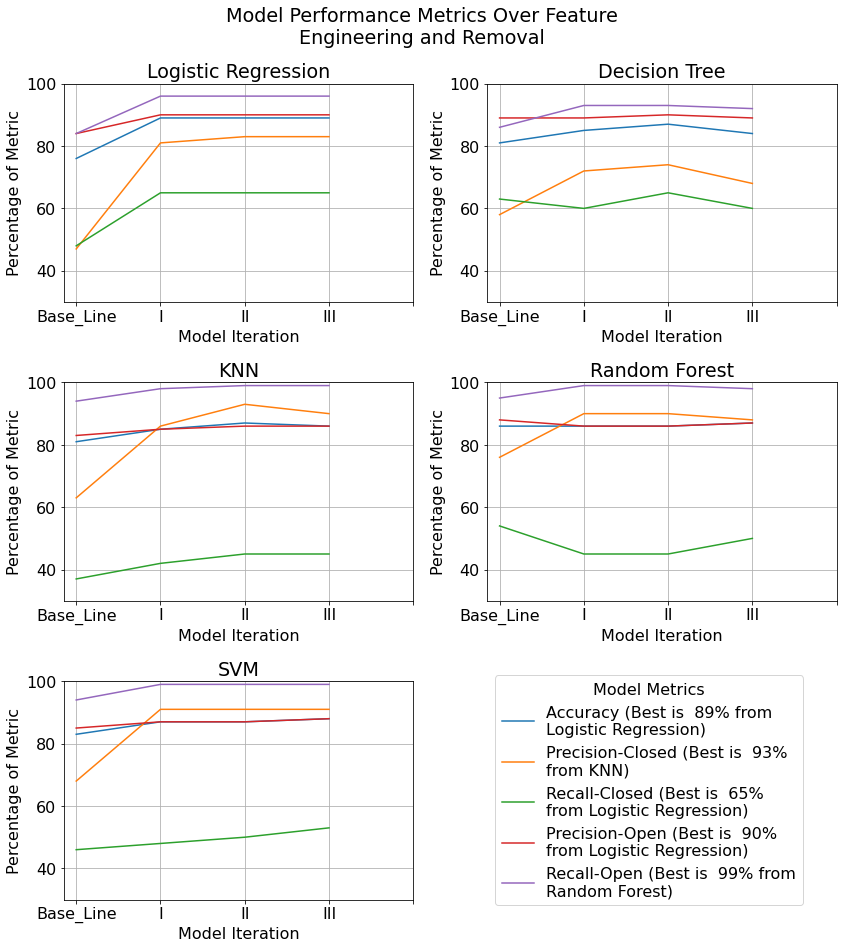

In [286]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df2, 'III')

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

As expected, over all there was little change in model performance.  Changes that did happen and are worth noting:
- The precision on closed days reduced on each of decision tree, KNN, and random forest to varying degrees
- Random forest saw an uptick in the recall on closed days
- SVM saw the recall on the closed stays continue a steady upward march.

### Model Iteration IV - Removing Snow Base Lags

As discussed in our EDA and baseline model iteration, there is a near perfect linear correlation between all of the snowpack variables.  We are going to now drop all of the snowpack lags and keep the day of measurements only.  Hopefully this will give a boost to our Linear Regression model which appears to still be our front runner.

In [287]:
# get all the day of the snowpack column names
snowpack_cols = [col for col in peak_df.columns if col.find('Snow on Grnd') != -1]

# remove day of snowpack column name from list
snowpack_cols.pop(snowpack_cols.index('Snow on Grnd (cm)_L0h'))

# drop day of snowpack columns and make a deep copy of the data frame
peak_df3 = peak_df2.drop(columns = snowpack_cols).copy(deep = True)

# check it worked
peak_df3.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Snow (cm)_L0h', 'Tot

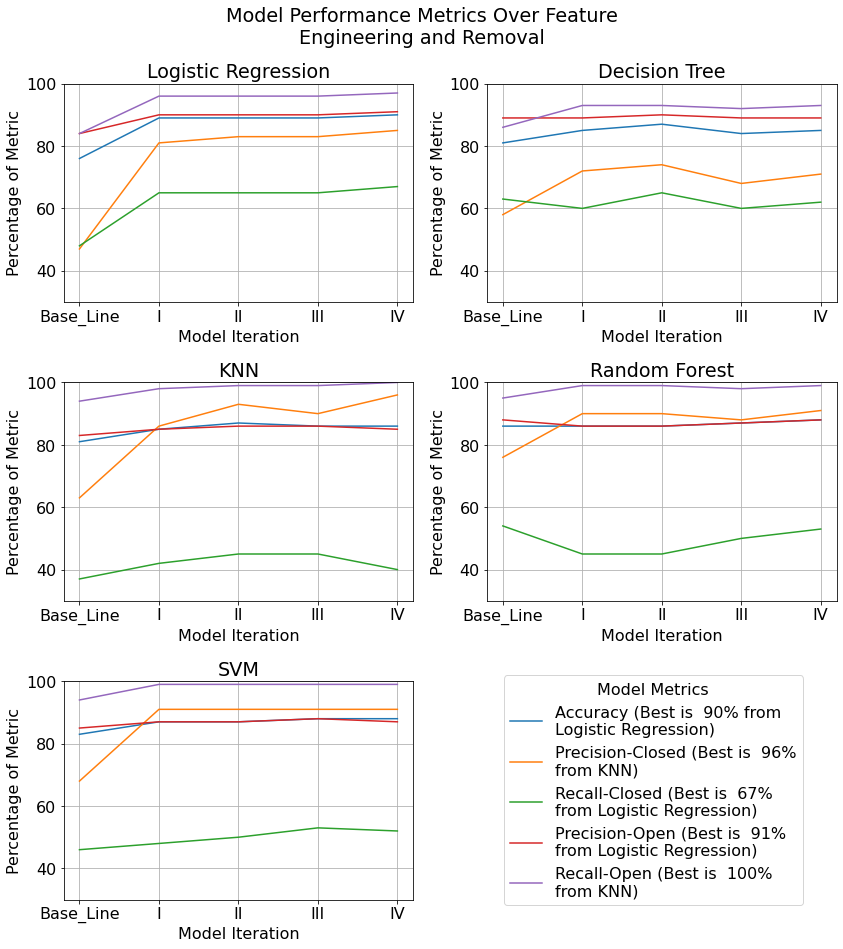

In [288]:
# run latest data against suite of models
latest_scores = split_fit_score(peak_df3, 'IV')

# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                                          columns = scores_df.columns),
                             ignore_index = True) # must reset index for plotting legend to work

# plot our metric tracking graph
plot_model_iterations(scores_df)

The results of dropping the lags for the snowpack have given us mostly improvements with a few blips downwards.  Notably:
- All our metrics on the logistic regression moved up slightly as was expected when removing co-linear variables.
- The KNN model shows a great visual of the trade off between precision and recall moving in opposite directions on the closed predictions.

### Model Iteration V - Engineering Snow Base Depth at 2,000m

As we saw during our EDA, the variance in the snow base depth on the day the Peak chair opened was almost 130 cm.  As discussed, that did not seem to make much sense to us.  We are going to attempt to engineer the snow depth at the mid point of the Peak chair based on the following approach:
- We will assume that 0 degrees celcius is the point at which rain becomes snow
- Using the Roundhouse/Pig Alley weather station elevation of 1640m and a mid point of [the Peak chair at 2,000m](https://whistlerplatinum.com/about-whistler/mountain-statistics/) we assume an elevation increase of 360m from the weather station to the mid point of the Peak chair
- At 100% relative humidity, the condition we have when it is raining or snowing, the temperature gradient as a function of elevation is [0.6 degrees celicus per 100m of elevation.](https://www.onthesnow.com/news/does-elevation-affect-temperature/)
- Combining the elevation change and temperature gradient we can infer a temperature at the 2,000m elevation
- We have rainfall data at the Pig Alley weather station
- If we have rain at the Pig Alley weather station and we have a temperature at the Pig Alley weather station that makes the interpolated temperature at 2,000m zero degrees celcius or lower, we can infer it is snowing at 2,000m.
- The ratio of rainfall to snow fall is an [increase in depth of 10x](https://sciencing.com/calculate-rain-snow-8344589.html).
- From our RoundhouseDataCleaningAndEDA report, we know that comparing snow fall to snow pack accumulation gives us a factor of 9/5.  This means depth of snow fall of $x$ will give an increase in snow pack of approximately $\frac{5}{9}x$
- Finally, for days where it rained, and the interpolated temperature is greater than 0 degress celcius, we will look at the reduction in snow pack at the Roundhouse elevation and assume the same amount of melting happened due to rain at the 2,000m elevation.
We do have to make one unforunate assumption.  Because we have discarded data earlier than the first date of the ski season, we will have to assume the snowpack depth on the first day of the season is uniform at all elevations.  We could go and get more data to make a more accurate prediction, but let's see how much this tightens up the variance in snow pack on the first day the Peak opens and how that affects our models first.

Let's define a function to do the interpolation for us, then add our new snow pack depth columns (one for each lag day), drop the snow pack old columns, visualize the variance, and run the new columns through our model.

In [158]:
# get copy of df to work with
peak_df3 = peak_df2.copy(deep = True)

# create a temporary column that gives us the difference between
# snow on the ground today and snow on the ground tomorrow.
peak_df3['snowpakc_diff'] = peak_df3['Snow on Grnd (cm)_L0h'].diff()

In [ ]:
def interpolate_snowpack(row):
    """
    Takes one row of our peak data frame and interpolates the snow pack at 2,000m as 
    per above outline.
    """
    # get current snow pack at 2,000m

    # calculate temperature at 2,000m

    # if temp at 2,000m is greater than 0

        # get snow on Grnd difference with next day

        # if difference is negative (lost snow due to rain)

            # remove that much snow from current snow pack at 2,000m

    # else temp at 2,000m was less than zero

        # calculate snowfall for that day

        # store snowfall for that day into Total Snow L0h

        # calculate increase in snow pack for that day

        # store increase in snow pack into the next days Snow on Grnd L0h
    